In [1]:
# importing the libraries 

import os
import re

import pandas as pd 
import numpy as np 

import tensorflow as tf
from keras import preprocessing
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

/var/folders/4k/byg8gjqx3ld5757qnw63s0v00000gn/T/ipykernel_58716/1422717650.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# data folders

train_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/train'
valid_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/valid'
test_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/test'

In [3]:
# creating a dataframe for the train folder with the images and their class 

train_images_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/train/images'
image_files_train = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]
class_labels_train = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_train]
train_df = pd.DataFrame({'filename': image_files_train, 'class': class_labels_train})

# creating a dataframe for the valid folder with the images and their class 

valid_images_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/valid/images'
image_files_valid = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]
class_labels_valid = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_valid]
validation_df = pd.DataFrame({'filename': image_files_valid, 'class': class_labels_valid})

# creating a dataframe for the test folder with the images and their class 

test_images_path = '/Users/vschuckar/Desktop/data_analytics/Week_9/final_project/dataset/test/images'
image_files_test = [file for file in os.listdir(test_images_path) if file.endswith('.jpg')]
class_labels_test = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_test]
test_df = pd.DataFrame({'filename': image_files_test, 'class': class_labels_test})

In [4]:
# confirming it has the right structure 

train_df['class'].value_counts()

class
1    433
5    315
0    306
4    299
2    283
3    168
Name: count, dtype: int64

In [5]:
# real-time data augmentation and preparing the data for training 

batch_size = 32  
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_images_path,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='sparse',  
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    directory=valid_images_path,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='sparse'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_images_path,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode=None,  
    shuffle=False  
)

Found 1804 validated image filenames belonging to 6 classes.
Found 173 validated image filenames belonging to 6 classes.
Found 83 validated image filenames.


In [6]:
# calling the pre trained model, unfreezing some layers, adding my layer, its output, and compiling

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
# training the model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model-res-net-best.h5', save_best_only=True)
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=2, callbacks=[early_stopping, checkpoint] )

Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 - 527s - loss: 1.5407 - accuracy: 0.4318 - val_loss: 4.5492 - val_accuracy: 0.2370 - 527s/epoch - 9s/step
Epoch 2/20
57/57 - 524s - loss: 1.0382 - accuracy: 0.6181 - val_loss: 3.6815 - val_accuracy: 0.2370 - 524s/epoch - 9s/step
Epoch 3/20
57/57 - 569s - loss: 0.8328 - accuracy: 0.6840 - val_loss: 1.8020 - val_accuracy: 0.1098 - 569s/epoch - 10s/step
Epoch 4/20
57/57 - 531s - loss: 0.6870 - accuracy: 0.7339 - val_loss: 1.8870 - val_accuracy: 0.2139 - 531s/epoch - 9s/step
Epoch 5/20
57/57 - 532s - loss: 0.6487 - accuracy: 0.7483 - val_loss: 2.6463 - val_accuracy: 0.2139 - 532s/epoch - 9s/step
Epoch 6/20
57/57 - 547s - loss: 0.5515 - accuracy: 0.7932 - val_loss: 1.7912 - val_accuracy: 0.2254 - 547s/epoch - 10s/step
Epoch 7/20
57/57 - 531s - loss: 0.4954 - accuracy: 0.8104 - val_loss: 1.7655 - val_accuracy: 0.2254 - 531s/epoch - 9s/step
Epoch 8/20
57/57 - 531s - loss: 0.4438 - accuracy: 0.8376 - val_loss: 2.0207 - val_accuracy: 0.1792 - 531s/epoch - 9s/step
Epoch 9/20
57/57 - 533s -

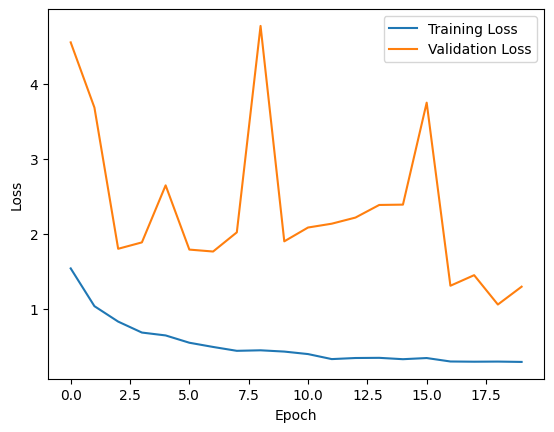

In [12]:
# plotting the val and training loss 

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# evaluating model on validation set

val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


6/6 [==============================] - 11s 2s/step - loss: 1.2975 - accuracy: 0.6185
Validation Loss: 1.297473430633545, Validation Accuracy: 0.6184971332550049


In [14]:
# predictions on the test set

test_predictions = model.predict(test_generator)

# printing the predicted class for each test image

test_predicted_classes = np.argmax(test_predictions, axis=1)
test_df['predicted_class'] = test_predicted_classes
print(test_df)



3/3 [==============================] - 5s 2s/step
          filename class  predicted_class
0   1_ecfcdf81.jpg     1                3
1   0_37b28d86.jpg     0                0
2   4_617cc4fc.jpg     4                4
3   1_ab5b5d51.jpg     1                4
4   4_f5a9c243.jpg     4                4
..             ...   ...              ...
78  4_76253060.jpg     4                5
79  0_617ae978.jpg     0                0
80  4_0c0be5b2.jpg     4                4
81  1_7093ab43.jpg     1                3
82  3_b592c43a.jpg     3                3

[83 rows x 3 columns]


In [15]:
# calling the true labels for the test set

true_labels = [int(label) for label in test_df['class']]

# accuracy

accuracy = accuracy_score(true_labels, test_predicted_classes)
print(f'Accuracy: {accuracy:.2%}')

# classification report

print('Classification Report:')
print(classification_report(true_labels, test_predicted_classes))

Accuracy: 61.45%
Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        13
           1       1.00      0.32      0.48        22
           2       0.60      0.23      0.33        13
           3       0.38      1.00      0.55         6
           4       0.71      0.71      0.71        14
           5       0.67      0.80      0.73        15

    accuracy                           0.61        83
   macro avg       0.65      0.68      0.59        83
weighted avg       0.72      0.61      0.58        83

Confusion Matrix:
[[13  0  0  0  0  0]
 [ 2  7  2  9  1  1]
 [ 5  0  3  1  2  2]
 [ 0  0  0  6  0  0]
 [ 1  0  0  0 10  3]
 [ 2  0  0  0  1 12]]


In [ ]:
# plotting a confusion matrix as a heatmap due to the number of classes 

cm = confusion_matrix(true_labels, test_predicted_classes)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()